In [2]:
import numpy as np
import pandas as pd
import pyabf
import matplotlib.pyplot as plt
import os
import pickle
import torch

In [13]:
def find_special_regions(signal, window_size, threshold_factor):
    """
    此函数用于找出电信号中特殊区域的索引。
    :param signal: 输入的电信号数组
    :param window_size: 滑动窗口的大小
    :param threshold_factor: 阈值因子，用于确定特殊区域的阈值
    :return: 特殊区域的索引列表
    """
    # 初始化局部平均值列表
    local_means = []
    # 信号长度
    n = len(signal)
    
    # 遍历信号，计算每个窗口的平均值
    for i in range(n - window_size + 1):
        window = signal[i:i + window_size]
        local_means.append(np.mean(window))
    
    # 计算所有窗口平均值的中位数
    median_mean = np.median(local_means)
    # 确定阈值
    threshold = median_mean * threshold_factor
    
    # 初始化特殊区域的索引列表
    special_regions = []
    start_index = None
    
    # 遍历局部平均值，找出低于阈值的区域
    for i, mean in enumerate(local_means):
        if mean < threshold:
            if start_index is None:
                start_index = i
        else:
            if start_index is not None:
                end_index = i + window_size - 1
                special_regions.append((start_index, end_index))
                start_index = None
    
    # 处理最后一个特殊区域
    if start_index is not None:
        end_index = n
        special_regions.append((start_index, end_index))
    
    return special_regions

def cross_entropy(label, pre):
    return -np.sum(label * np.log(pre)) / len(label)

def compare(label, pre):
    return np.sum(label == pre) / len(label)


In [24]:
for list_i in range(len(path_list)):
    for path_j in range(len(path_list[list_i])):
        data_path = path_list[list_i][path_j]
        abf = pyabf.ABF(data_path)
        x = abf.getAllXs()
        y = abf.getAllYs()
        tag = abf.tagTimesSec
        sample_rate = abf.dataRate
        class_label = list_i
        tag_comments = abf.tagComments
        sweepLengthSec = abf.sweepLengthSec
        print(data_path, sample_rate, sweepLengthSec, len(tag))

data/T1-2/repeat1-T1-2.abf 5000 601.7536 4
data/T1-2/repeat2-T1-2.abf 5000 603.9552 49
data/T1-2/repeat3-T1-2.abf 5000 601.9584 13
data/T1-2/repeat4-T1-2.abf 5000 1802.7008 18
data/T1-2/repeat5-T1-2.abf 5000 600.6272 1
data/T1-3/repeat1-T1-3.abf 100000 607.0272 47
data/T1-3/repeat2-T1-3.abf 100000 602.3168 18
data/T1-3/repeat3-T1-3.abf 100000 1800.6528 48
data/T1-3/repeat4-T1-3.abf 100000 600.4736 99
data/T1-4/Repeat1-T1-4.abf 100000 497.408 76
data/T1-4/Repeat2-T1-4.abf 100000 599.0912 163
data/T1-4/Repeat3-T1-4.abf 100000 603.3408 114
data/T1-5/Repeat1-T1-5.abf 100000 1818.0608 98
data/T1-5/Repeat2-T1-5.abf 100000 844.032 23
data/T1-5/Repeat3-T1-5.abf 100000 600.8832 16
data/T1-5/Repeat4-T1-5.abf 100000 603.0848 12
data/T1-5/Repeat5-T1-5.abf 100000 840.192 66
data/T1-6/repeat1-T1-6.abf 100000 688.128 44
data/T1-6/repeat2-T1-6.abf 100000 1263.0528 0
data/T1-6/repeat3-T1-6.abf 100000 903.168 18


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_list_1 = ['data/T1-2/repeat1-T1-2.abf','data/T1-2/repeat2-T1-2.abf','data/T1-2/repeat3-T1-2.abf','data/T1-2/repeat4-T1-2.abf','data/T1-2/repeat5-T1-2.abf']
path_list_2 = ['data/T1-3/repeat1-T1-3.abf','data/T1-3/repeat2-T1-3.abf','data/T1-3/repeat3-T1-3.abf','data/T1-3/repeat4-T1-3.abf']
path_list_3 = ['data/T1-4/Repeat1-T1-4.abf','data/T1-4/Repeat2-T1-4.abf','data/T1-4/Repeat3-T1-4.abf']
path_list_4 = ['data/T1-5/Repeat1-T1-5.abf','data/T1-5/Repeat2-T1-5.abf','data/T1-5/Repeat3-T1-5.abf','data/T1-5/Repeat4-T1-5.abf','data/T1-5/Repeat5-T1-5.abf']
path_list_5 = ['data/T1-6/repeat1-T1-6.abf','data/T1-6/repeat2-T1-6.abf','data/T1-6/repeat3-T1-6.abf']
event_path = 'data_event/'
path_list = [path_list_1,path_list_2, path_list_3, path_list_4, path_list_5]

for list_i in range(len(path_list)):
    for path_j in range(len(path_list[list_i])):
        data_path = path_list[list_i][path_j]
        abf = pyabf.ABF(data_path)
        x = abf.getAllXs()
        y = abf.getAllYs()
        tag = abf.tagTimesSec
        sample_rate = abf.dataRate
        class_label = list_i
        tag_comments = abf.tagComments
        sweepLengthSec = abf.sweepLengthSec
        print(data_path, sample_rate, sweepLengthSec, len(tag))

        tag_x_index = np.array([np.where(x == i) for i in tag]).squeeze()
        tag_type = np.array(['-' in tag_comments[i] for i in range(len(tag_comments))])
        if tag_x_index.ndim == 0:
            tag_x_index = np.array([tag_x_index])

        mask = np.ones(len(x), dtype=bool)
        for i, tag_x in enumerate(tag_x_index):
            if tag_type[i]:
                start_idx = int(max(tag_x - 0.2 * sample_rate, 0))
                window_start = start_idx
                last_tag_x_index = tag_x_index[i - 1] if i > 0 else 0
                while (window_start > last_tag_x_index) and (y[window_start - 1] < 200):
                    window_start -= 1
                window_end = tag_x_index[i + 1] if i < len(tag_x_index) - 1 else len(x)
                mask[window_start:window_end] = False
            else:
                window_start = int(max(tag_x - 0.2 * sample_rate, 0))
                window_end = int(min(tag_x + 0.5 * sample_rate, len(x)))
                mask[window_start:window_end] = False
        mask = torch.tensor(mask, dtype=torch.bool, device=device)
        #将标记位置的值改为平均值
        y = torch.tensor(y, dtype=torch.float32, device=device)
        mean_value = torch.mean(y[mask])
        y[~mask] = mean_value
        #统一采样率为5000Hz
        target_sample_rate = 5000
        x = x[::int(sample_rate / target_sample_rate)]
        y = y[::int(sample_rate / target_sample_rate)]
        #将处理好的数据保存为pickle
        save_path = 'data_pickle/' + data_path.split('/')[-1].split('.')[0] + '.pickle'
        with open(save_path, 'wb') as f:
            pickle.dump((x, y, sample_rate), f)
        

data/T1-2/repeat1-T1-2.abf 5000 601.7536 4
data/T1-2/repeat2-T1-2.abf 5000 603.9552 49
data/T1-2/repeat3-T1-2.abf 5000 601.9584 13
data/T1-2/repeat4-T1-2.abf 5000 1802.7008 18
data/T1-2/repeat5-T1-2.abf 5000 600.6272 1
data/T1-3/repeat1-T1-3.abf 100000 607.0272 47
data/T1-3/repeat2-T1-3.abf 100000 602.3168 18
data/T1-3/repeat3-T1-3.abf 100000 1800.6528 48
data/T1-3/repeat4-T1-3.abf 100000 600.4736 99
data/T1-4/Repeat1-T1-4.abf 100000 497.408 76
data/T1-4/Repeat2-T1-4.abf 100000 599.0912 163


KeyboardInterrupt: 

In [ ]:
pickle_path = './data_pickle/'
event_path = 'data_event/'
file_result = []
cross_result = []
Similarity_result = []
for f in os.listdir(pickle_path):
    path = pickle_path + f
    slice_data = []
    with open(path, 'rb') as f:
        x, y, sample_rate = pickle.load(f)
        y = y.cpu()
        y = y.numpy()
        #打开同名的excel
        event = pd.read_excel(event_path + path.split('/')[-1].split('.')[0] + '.xlsx')
        label = np.zeros(len(x))
        for i in range(len(event)):
            if sample_rate == 100000:
                start = event.iloc[i, 1]//20
                end = event.iloc[i, 2]//20
                label[int(start):int(end)] = 1
            else:
                start = event.iloc[i, 1]
                end = event.iloc[i, 2]
                label[int(start):int(end)] = 1
        special_regions = find_special_regions(y, window_size=10, threshold_factor=0.8)
        pre = np.zeros(len(x))
        for start, end in special_regions:
            pre[start:end] = 1
        #储存结果
        print('file name:', path.split('/')[-1].split('.')[0])
        file_result.append(path.split('/')[-1].split('.')[0])
        cross = cross_entropy(label, pre)
        cross_result.append(cross)
        print('cross_entropy:', cross.item())
        Similarity = compare(label, pre)
        Similarity_result.append(Similarity)
        print('Similarity:', Similarity.item())
        
        #根据special_regions的结果，将数据切片储存
        for i, (start, end) in enumerate(special_regions):
            slice_data.append(y[start:end])
        save_path = 'data_slice/' + path.split('/')[-1].split('.')[0] + '.pickle'
        with open(save_path, 'wb') as f:
            pickle.dump(slice_data, f)
                
        

file name: repeat1-T1-6
cross_entropy: 0.15884212582972712
Similarity: 0.7699596586681547
file name: repeat4-T1-3
cross_entropy: 0.025201089990066265
Similarity: 0.8113059425093793
file name: repeat5-T1-2
cross_entropy: 0.0011347557733025354
Similarity: 0.9392828030432189
file name: Repeat4-T1-5
cross_entropy: 0.029085616541251805
Similarity: 0.5692907531411835
file name: repeat3-T1-6
cross_entropy: 0.0023760909448355865
Similarity: 0.9317435958758503
file name: repeat1-T1-2
cross_entropy: 0.000619886244189208
Similarity: 0.9078712615927849
file name: Repeat3-T1-4
cross_entropy: 0.11285834866322172
Similarity: 0.515765219259165
file name: Repeat2-T1-5
cross_entropy: 0.015184481894924884
Similarity: 0.6107249488171065
file name: repeat2-T1-3
cross_entropy: 0.0021943333496253835
Similarity: 0.6058539293607617
file name: repeat3-T1-2
cross_entropy: 0.02346351001615521
Similarity: 0.7404930307476397
file name: Repeat1-T1-4
cross_entropy: 0.006573418264117473
Similarity: 0.6650484109624293


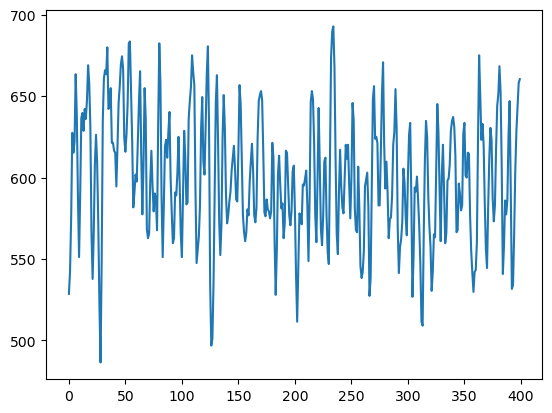

In [ ]:
abf = pyabf.ABF('data/T1-6/repeat3-T1-6.abf')

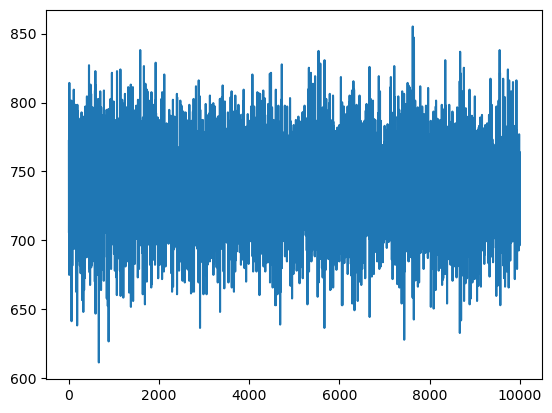

In [23]:
x = abf.getAllXs()
y = abf.getAllYs()
plt.plot(y[:10000])